In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
%matplotlib inline

from data_builder import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pickle
from model_builder import get_models

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def duffing(num_samples, T_max, dt, noise_std=0, seed=1, type=1):
    """simple pendulum"""

    def hamiltonian_fn(coords, t):
        q, p = np.split(coords, 2)
        alpha = 1
        beta = 1
        omega = 1.2
        delta = 0
        gamma = .2
        H = alpha * (q ** 2) / 2 + (p ** 2) / 2 + beta * (q ** 4) / 4 - q * gamma * sin(
            omega * t)  # pendulum hamiltonian
        return H

    def dynamics_fn(t, coords):
        # dcoords = autograd.grad(hamiltonian_fn)(coords, t)

        # dqdt, dpdt = np.split(dcoords, 2)
        # S = np.concatenate([dpdt, -dqdt], axis=-1)
        q, p = np.split(coords, 2)
        alpha = -1
        beta = 1
        omega = 1.2
        delta = 0.3
        gamma = .2
        if type == 1:
            S = np.concatenate([p,-alpha*q-beta*q**3-delta*p+gamma*sin(omega*t)],axis=-1)
        if type == 2:
            gamma = 0.5
            S = np.concatenate([p, -alpha * q - beta * q ** 3 - delta * p + gamma * sin(omega * t)], axis=-1)
        if type == 3:
            # alpha =1
            # beta = 5
            omega = 1.4
            gamma, delta = 0.39, 0.1
            S = np.concatenate([p,  q - q ** 3 - delta * p + gamma * cos(omega * t)], axis=-1)
        return S

    def get_trajectory(t_span=[0, T_max], timescale=dt):
        t_eval = np.arange(t_span[0], t_span[1], timescale)
        y0 = np.random.rand(2) * 2 - 1
        radius = np.sqrt(np.random.uniform(0.5, 1.5))  # np.random.rand() * 0.9 + 0.1  # sample a range of radii
        y0 = y0 / np.sqrt((y0 ** 2).sum()) * (radius)
        if type == 3:
            y0 = [0., 0.]
            omega = 1.4
            dt_per_period = 100
            period = 2 * np.pi / omega
            dt = 2 * np.pi / omega / dt_per_period
            t_span = [0, 18000]
            t_eval = np.arange(0, 18000, dt)
        spring_ivp = rk(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
        q, p = spring_ivp['y'][0], spring_ivp['y'][1]
        dydt = [dynamics_fn(t_eval[i], y) for i, y in enumerate(spring_ivp['y'].T)]
        dydt = np.stack(dydt).T
        dqdt, dpdt = np.split(dydt, 2)

        # add noise
        q += np.random.randn(*q.shape) * noise_std
        p += np.random.randn(*p.shape) * noise_std
        return q, p, dqdt, dpdt, t_eval

    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    ssr = 1  # int(srate / dt)
    energies = []
    tvalues = []
    for s in range(num_samples):
        x, y, dx, dy, t = get_trajectory()
        x = x[::ssr]
        y = y[::ssr]
        dx = dx[::ssr]
        dy = dy[::ssr]
        xs.append(np.stack([x, y]).T)
        energies.append([hamiltonian_fn(xs[-1][i], t[i]) for i in range(len(xs[-1]))])
        dxs.append(np.stack([dx, dy]).T)
        tvalues.append(t)

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()
    data['energy'] = np.concatenate(energies)
    data['tvalues'] = np.concatenate(tvalues)
    return data

In [3]:
omega = 1.4
dt_per_period = 100
period = 2 * np.pi / omega
dt = 2 * np.pi / omega / dt_per_period

In [4]:
tevals = torch.arange(0,period,dt)
tevals.to('cpu')
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(f.detach().numpy(),label='pred')
plt.plot(0.39*np.cos(1.4*tevals.detach().numpy()),label='gt')
plt.legend()

NameError: name 'model_type' is not defined

In [5]:
test_data = duffing(1, 18000, 0.1, noise_std=0, seed=5, type=3)

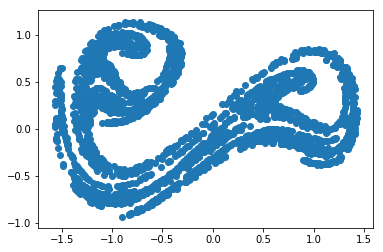

In [6]:
pstep = 100
plt.scatter(test_data['x'][::pstep,0],test_data['x'][::pstep,1])

In [7]:
test_data['x'][0]

array([0., 0.])

In [7]:
def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        omega = 1.4
        period = 2 * np.pi / omega
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( np.mod(t,period), requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)
def test_model(model_name,model):
    # Each epoch has a training and validation phase
    q = test_data['x']
    t = test_data['tvalues']
#     q.requires_grad = True
#     tevals.requires_grad = True

    qinit = q[0]
    omega = 1.4
    dt_per_period = 100
    period = 2 * np.pi / omega
    dt = 2 * np.pi / omega / dt_per_period
    preds = integrate_model(model,[0,18000],qinit.ravel(),t_eval=np.arange(0, 18000, dt)).y
    main_pred[model_name].append((preds.T,q))
    





In [8]:
# model_ft = HNN(2, 200, 1, 0.01)
main_pred={'baseline':[],'TDHNN4':[]}

model_nms = list(main_pred.keys())
for model_name in model_nms:
    model_type = torch.load(f'duffing_3/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

In [9]:
pstep =100

In [10]:
sns.set_context("paper",font_scale=5.4, rc={'figure.figsize':(5,5),"font.size":40,"axes.titlesize":30,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette("Accent")


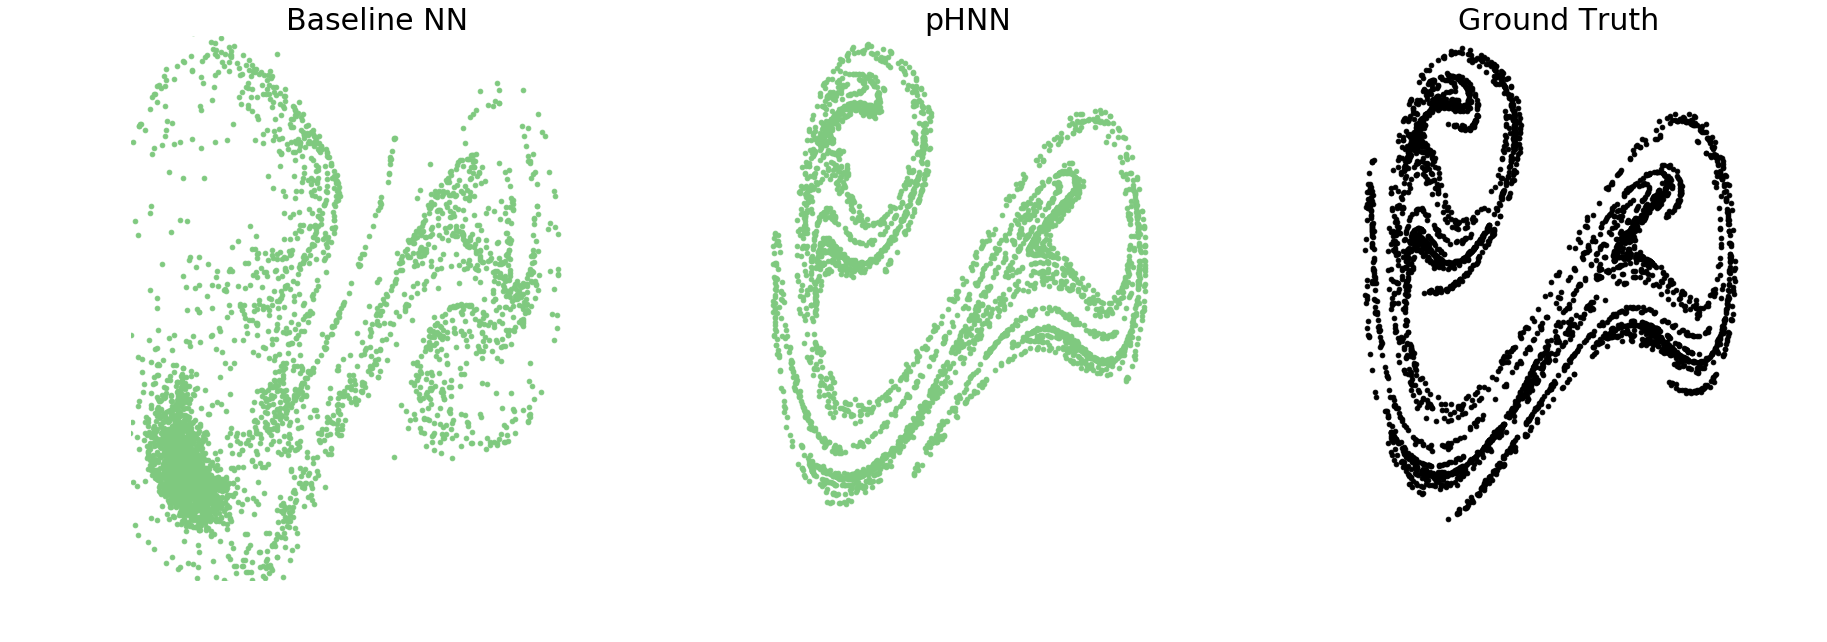

In [12]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
# plt.figure(figsize=(15,10))

ax[0].scatter(main_pred['baseline'][0][0][::pstep,0],main_pred['baseline'][0][0][::pstep,1],label='predicted')
ax[0].set_title('Baseline NN')

ax[1].scatter(main_pred['TDHNN4'][0][0][::pstep,0],main_pred['TDHNN4'][0][0][::pstep,1],label='predicted')
ax[1].set_title('pHNN')

ax[2].scatter(test_data['x'][::pstep,0],test_data['x'][::pstep,1],c='black',label='ground truth')
ax[2].set_title('Ground Truth')
ax[2].set_xlim([-2,2])
ax[2].set_ylim([-1.2,1.2])

ax[1].set_xlim([-2,2])
ax[1].set_ylim([-1.2,1.2])

ax[0].set_xlim([-2,2])
ax[0].set_ylim([-1.2,1.2])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# plt.tight_layout()
plt.savefig('main_fig.pdf',dpi=2400,bbox_inches='tight')

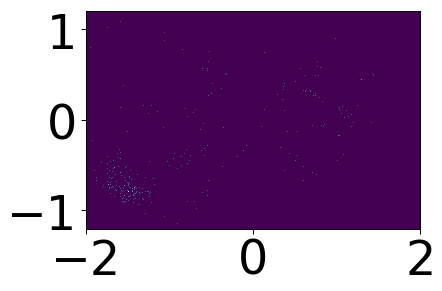

In [52]:
plt.figure()
plt.xlim([-2,2])
plt.ylim([-1.2,1.2])

gt =plt.hist2d(test_data['x'][::pstep,0],test_data['x'][::pstep,1],bins=1000,range=[[-2,2],[-1.2,1.2]],normed=True)[0]
phnn = plt.hist2d(main_pred['TDHNN4'][0][0][::pstep,0],main_pred['TDHNN4'][0][0][::pstep,1],bins=1000,normed=True,range=[[-2,2],[-1.2,1.2]])[0]
bnn = plt.hist2d(main_pred['baseline'][0][0][::pstep,0],main_pred['baseline'][0][0][::pstep,1],bins=1000,normed=True,range=[[-2,2],[-1.2,1.2]])[0]

In [61]:
def intersect_map(a,b):
    zz = np.zeros(a.shape)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if (a[i,j] == 1) and (b[i,j] == 1):
                zz[i,j] = 1
    return zz

In [62]:
gtphnn = intersect_map(gt,phnn)
gtbnn = intersect_map(gt,bnn)

In [65]:
gtphnn.sum()/,gtbnn.sum()

(154.0, 15.0)

In [71]:
len(gt[gt!=0])

3707

In [54]:
gt[gt!=0]=1
phnn[phnn!=0]=1
bnn[bnn!=0]=1

In [60]:
gt&phnn

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [57]:
(gt==phnn).sum(),(gt==bnn).sum()

(992840, 992608)

In [51]:
((gt-phnn)**2).mean(),((gt-bnn)**2).mean()

(0.11051600069807198, 0.28709843547686653)

In [ ]:
((gt-phnn)**2).mean(),((gt-bnn)**2).mean()

In [ ]:
qs = np.linspace(-2,2,1000)
ps = np.linspace(-1.2,1.2,1000)
QS,PS = np.gridspace()

In [22]:
(np.abs(main_pred['baseline'][0][0][::pstep] - test_data['x'][::pstep])).mean()

0.9650304998285889

In [21]:
(np.abs(main_pred['TDHNN4'][0][0][::pstep] - test_data['x'][::pstep])).mean()

0.7521103292011029

In [17]:
np.linalg.norm(main_pred['baseline'][0][0][::pstep] - test_data['x'][::pstep],ord=np.inf)

4.932597670096859

In [18]:
np.linalg.norm(main_pred['TDHNN4'][0][0][::pstep] - test_data['x'][::pstep],ord=np.inf)

3.9249772993963967

Text(0.5, 1.0, 'Predicted')

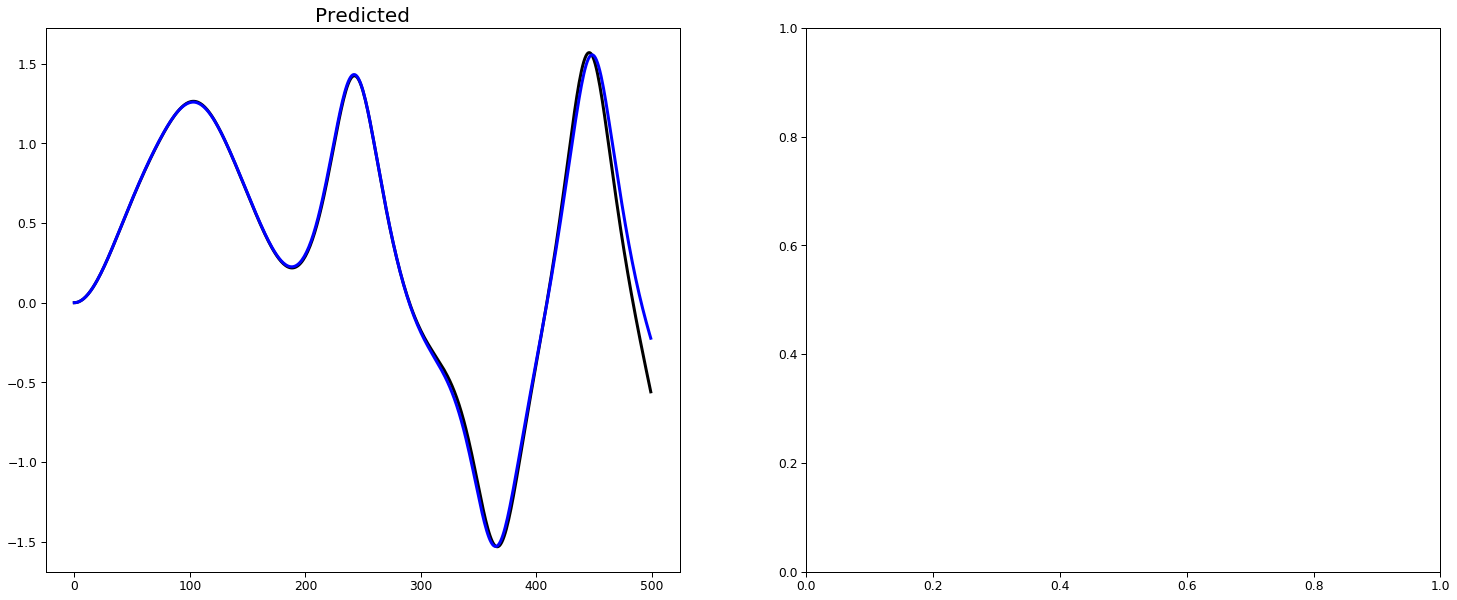

In [53]:
fig,ax = plt.subplots(1,2,figsize=(25,10))
# plt.figure(figsize=(15,10))
ax[0].plot(test_data['x'][:500,0],c='black',label='ground truth')
ax[0].set_title('Ground Truth')

ax[0].plot(main_pred['TDHNN4'][0][0][:500,0],c='blue',label='predicted')
ax[0].set_title('Predicted')


# ax[1].plot(main_pred['TDHNN4'][0][0][::pstep,0],c='blue',label='predicted')
# ax[1].set_title('Predicted')



Text(0.5, 1.0, 'Ground Truth')

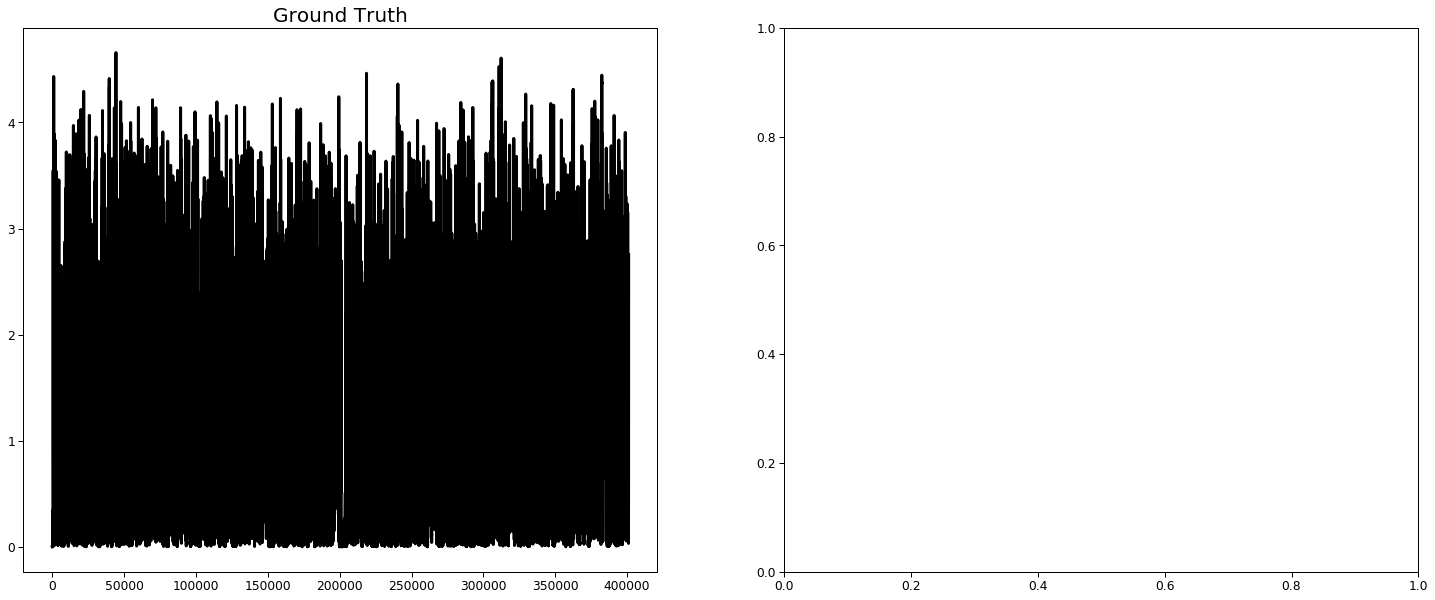

In [46]:
fig,ax = plt.subplots(1,2,figsize=(25,10))
# plt.figure(figsize=(15,10))
ax[0].plot(np.mean(np.square(test_data['x']-main_pred['TDHNN4'][0][0]),1),c='black',label='ground truth')
ax[0].set_title('Ground Truth')

# ax[1].plot(main_pred['TDHNN4'][0][0][::pstep,0],c='blue',label='predicted')
# ax[1].set_title('Predicted')



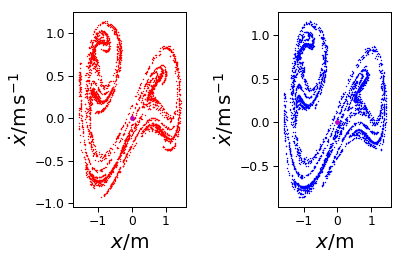

In [61]:
# The animation
fig, ax = plt.subplots(nrows=1,ncols=2)
x = test_data['x'][:,0]
xdot = test_data['x'][:,1]
# Poincaré section plot
ax4 = ax[0]
ax4.set_xlabel(r'$x / \mathrm{m}$')
ax4.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ax4.scatter(x[::pstep], xdot[::pstep], s=2, lw=0, c='r')
scat1 = ax4.scatter([0], [0], lw=0, c='m')

x = main_pred['TDHNN4'][0][0][:,0]
xdot = main_pred['TDHNN4'][0][0][:,1]
# Poincaré section plot
ax4 = ax[1]
ax4.set_xlabel(r'$x / \mathrm{m}$')
ax4.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ax4.scatter(x[::pstep], xdot[::pstep], s=2, lw=0, c='b')
scat1 = ax4.scatter([0], [0], lw=0, c='m')


plt.tight_layout()

# def animate(i):
#     """Update the image for iteration i of the Matplotlib animation."""

#     ln1.set_data(x[i], V(x[i]))
#     ln2.set_data(t[:i+1], x[:i+1])
#     ax2.set_xlim(t_trans, t[i])
#     ln3.set_data(x[:i+1], xdot[:i+1])
#     if not i % pstep:
#         scat1.set_offsets(X[i])
#     return

# anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=1)

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# anim.save('duffing.mp4', writer=writer)


In [25]:
train_data = get_dataset('duffing', 20, 3, 0.1, 0, seed=0,type=3)


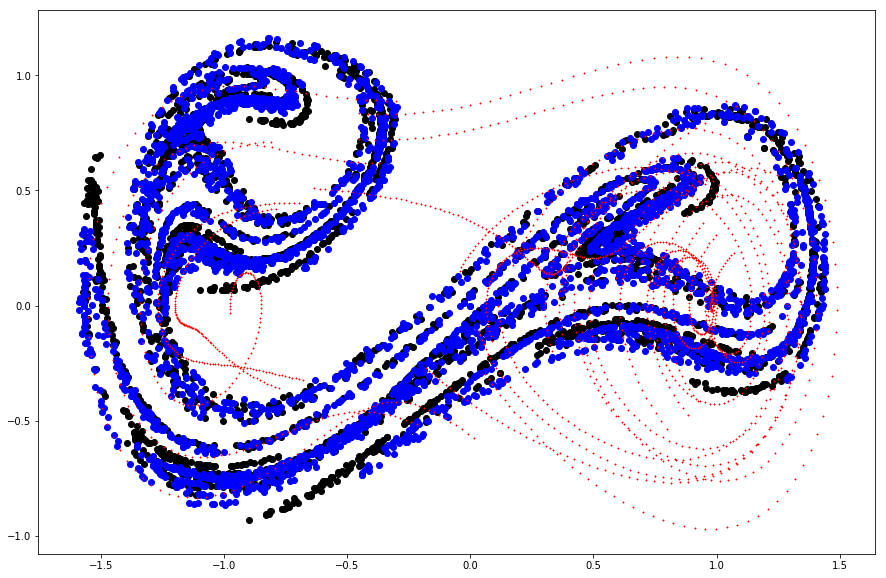

In [30]:
plt.figure(figsize=(15,10))
plt.scatter(test_data['x'][::pstep,0],test_data['x'][::pstep,1],c='black')
plt.scatter(main_pred['TDHNN4'][0][0][::pstep,0],main_pred['TDHNN4'][0][0][::pstep,1],c='blue')
plt.scatter(train_data['x'][:,0],train_data['x'][:,1],c='red',marker='x',s=0.8)





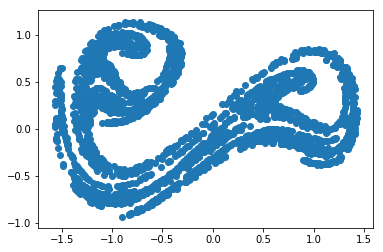

In [16]:
plt.scatter(main_pred['TDHNN4'][0][1][::pstep,0],main_pred['TDHNN4'][0][1][::pstep,1])





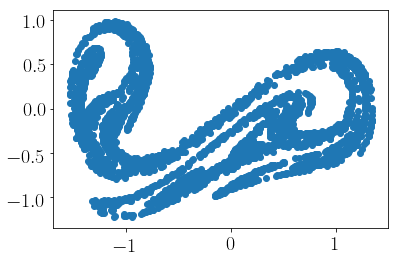

In [50]:
plt.scatter(x[::pstep],xdot[::pstep])

In [34]:
deriv([0,0],0,gamma,delta,omega)

(0, 0.39)

In [39]:
def dynamics_fn(coords,t):
    # dcoords = autograd.grad(hamiltonian_fn)(coords, t)

    # dqdt, dpdt = np.split(dcoords, 2)
    # S = np.concatenate([dpdt, -dqdt], axis=-1)
    q, p = np.split(coords,2)
    omega = 1.4
    gamma, delta = 0.39, 0.1
    S = np.concatenate([p,  q - q ** 3 - delta * p + gamma * np.cos(omega * t)], axis=-1)
    return S

In [40]:
dynamics_fn(np.array([0,0]),0)

array([0.  , 0.39])

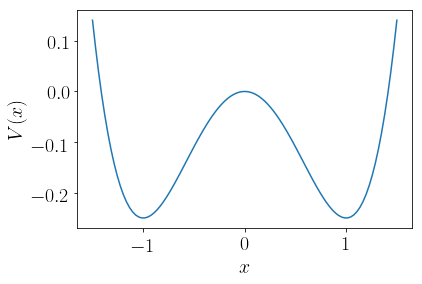

In [31]:
import numpy as np
from scipy.integrate import odeint, quad
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sbs
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)
rc('animation', html='html5')

# The potential and its first derivative, as callables.
V = lambda x: 0.5 * x**2 * (0.5 * x**2 - 1)
dVdx = lambda x: x**3 - x

# The potential energy function on a grid of x-points.
xgrid = np.linspace(-1.5, 1.5, 100)
Vgrid = V(xgrid)

plt.plot(xgrid, Vgrid)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

def deriv(X, t, gamma, delta, omega):
    """Return the derivatives dx/dt and d2x/dt2."""

    x, xdot = X
    xdotdot = -dVdx(x) -delta * xdot + gamma * np.cos(omega*t)
    return xdot, xdotdot

def solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega):
    """Solve the Duffing equation for parameters gamma, delta, omega.

    Find the numerical solution to the Duffing equation using a suitable
    time grid: tmax is the maximum time (s) to integrate to; t_trans is
    the initial time period of transient behaviour until the solution
    settles down (if it does) to some kind of periodic motion (these data
    points are dropped) and dt_per_period is the number of time samples
    (of duration dt) to include per period of the driving motion (frequency
    omega).

    Returns the time grid, t (after t_trans), position, x, and velocity,
    xdot, dt, and step, the number of array points per period of the driving
    motion.

    """
    # Time point spacings and the time grid

    period = 2*np.pi/omega
    dt = 2*np.pi/omega / dt_per_period
    step = int(period / dt)
    t = np.arange(0, tmax, dt)
    # Initial conditions: x, xdot
    X0 = [x0, v0]
    X = odeint(deriv, X0, t, args=(gamma, delta, omega))
    idx = int(t_trans / dt)
    return t[idx:], X[idx:], dt, step

# Set up the motion for a oscillator with initial position
# x0 and initially at rest.
x0, v0 = 0, 0
tmax, t_trans = 18000, 300
omega = 1.4
gamma, delta = 0.39, 0.1
dt_per_period = 100

# Solve the equation of motion.
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega)
x, xdot = X.T

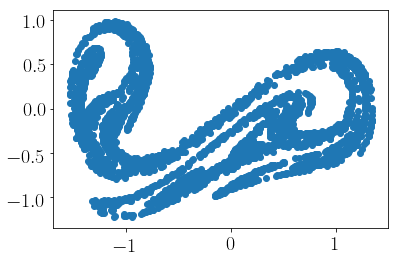

In [32]:
plt.scatter(x[::pstep],xdot[::pstep])

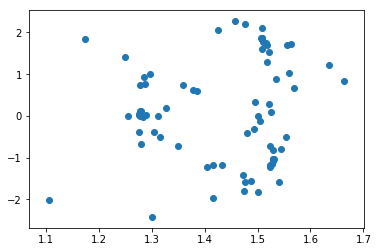

In [24]:
plt.scatter(res['x'][::,0],res['x'][::,1])

In [25]:
res['x'].shape

(1000, 2)

In [8]:
yhat = main_pred['TDHNN4'][0][0][:-1]#main_pred_coll[dex]
plt.plot(yhat[::20,0],yhat[::20,1])

IndexError: list index out of range

In [6]:
# model_ft = HNN(2, 200, 1, 0.01)
model_dct = get_models(dt, type=None, hidden_dim=200)
model_nms = ['TDHNN4']
for model_name in model_nms:
    model_type = torch.load(f'{dataset_name}/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

In [28]:
def hamiltonian_fn(coords):
    alpha = -1
    beta = 1
    omega = 1.2
    delta = 0.3
    gamma = 0.2
    q, p = coords[:,0],coords[:,1]
    t = np.arange(0,T_max_t,dt)[1:]
    H = alpha*q ** 2 / 2 + p ** 2/2  +beta*q**4/4 - q * gamma*sin(omega * t) # pendulum hamiltonian

    return H

In [29]:
avg_perf = {}
import pandas as pd
new_df = pd.DataFrame(columns=['Method','State Error','Energy Error'])

for model in model_nms:
    vals = main_pred[model]
    for i in range(len(vals)):
        pred = vals[i][0][:-1]
        true = vals[i][1]
        state_error = np.mean(np.square(pred-true))
        energy_error = np.mean(np.square(hamiltonian_fn(pred)-hamiltonian_fn(true)))
        new_df.loc[len(new_df)] = [model,state_error,energy_error]

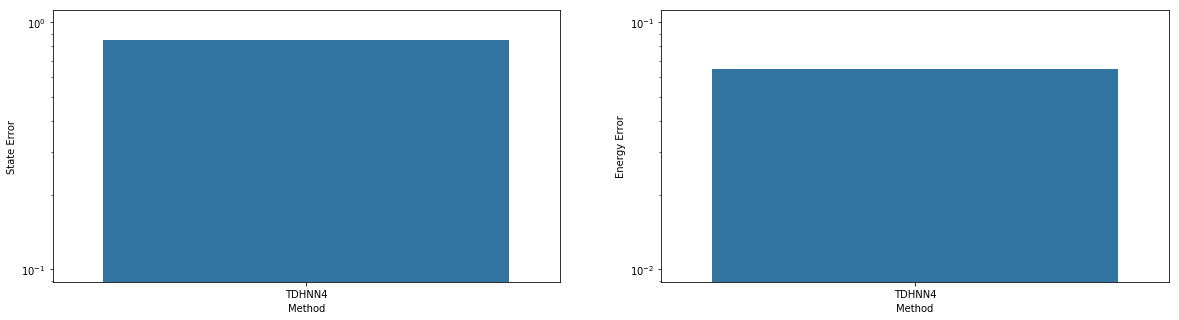

In [30]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.set_context("poster")
g = sns.barplot(x='Method',y='State Error',data=new_df,ax=ax[0])
g.set_yscale('log')

g = sns.barplot(x='Method',y='Energy Error',data=new_df,ax=ax[1])
g.set_yscale('log')

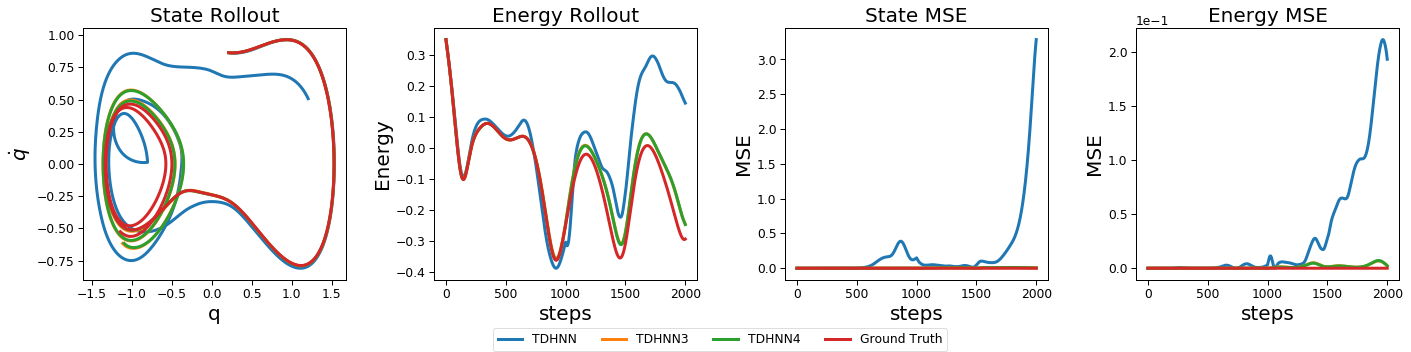

In [16]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
# model_nms = ['TDHNN','TDHNN3']
lab_list = model_nms
fig,axs = plt.subplots(1,4,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('TDHNN')

# lab_list.remove('TDHNN')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][0][0][:-1]#main_pred_coll[dex]
    true_batch = main_pred[name][0][1]
                    
    K_pred = hamiltonian_fn(yhat)
    K_true = hamiltonian_fn(true_batch)
    ham_pred = K_pred 
    ham_true = K_true 
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('steps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('steps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('mass_spring_long.pdf',dpi=2400,bbox_inches='tight')


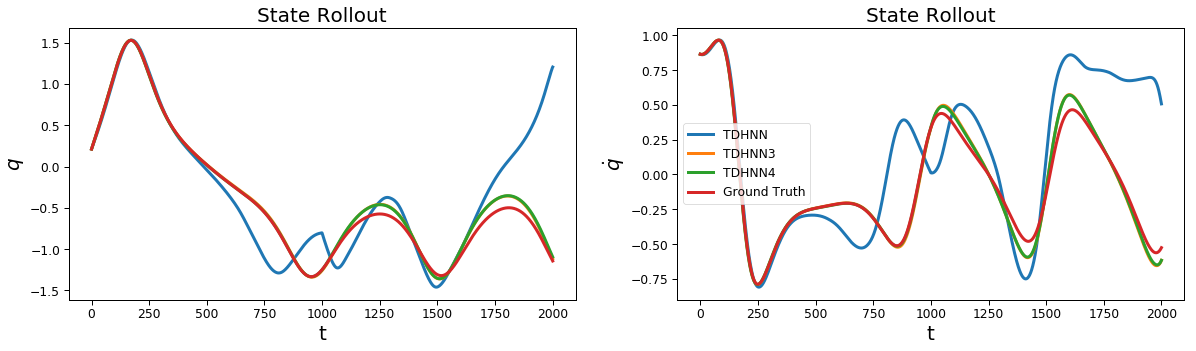

In [17]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = model_nms
fig,axs = plt.subplots(1,2,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][0][0][:-1]#main_pred_coll[dex]
    true_batch = main_pred[name][0][1]
                    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=range(len(yhat)),y=yhat[::,0],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('t')
    ax[0].set_ylabel(r'$q$')
    
    ax[1].set_title('State Rollout')
    sns.lineplot(x=range(len(yhat)),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[1],legend=False)
    
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[1].set_xlabel('t')
    ax[1].set_ylabel(r'$\dot{q}$')

sns.lineplot(x=range(len(yhat)),y=true_batch[:,0],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(yhat)),y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[1],sort=False,legend=False)
plt.legend()


In [9]:
model_type

TDHNN3(
  (mlp1): Linear(in_features=2, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=200, bias=True)
  (mlp4): Linear(in_features=200, out_features=1, bias=False)
  (f1): Linear(in_features=1, out_features=200, bias=True)
  (f2): Linear(in_features=200, out_features=200, bias=True)
  (f2_): Linear(in_features=200, out_features=200, bias=True)
  (f3): Linear(in_features=200, out_features=1, bias=False)
  (d1): Linear(in_features=1, out_features=1, bias=False)
)

In [10]:
for name, param in model_type.named_parameters():
    if param.requires_grad:
        print (name, param.data)

mlp1.weight tensor([[-1.0741e-01,  2.6534e-02],
        [ 7.8728e-02,  5.2511e-03],
        [ 1.9827e-02, -8.5258e-02],
        [-1.4740e-01, -1.2781e-01],
        [ 1.4940e-01, -1.1996e-01],
        [-5.2060e-02,  1.3818e-01],
        [-5.6848e-02,  8.1233e-02],
        [ 1.2370e-01, -9.2589e-02],
        [ 3.8203e-02, -1.2337e-03],
        [ 1.9620e-02, -7.6791e-02],
        [ 3.1641e-02, -1.6127e-02],
        [ 1.5837e-01, -1.8240e-02],
        [ 9.1620e-02,  3.9022e-02],
        [ 7.8249e-02,  1.4312e-01],
        [ 4.3458e-02,  6.5884e-02],
        [ 6.2755e-02, -1.1866e-02],
        [-6.7855e-02,  8.4886e-02],
        [-1.2918e-01,  4.8855e-02],
        [ 9.1713e-02,  1.2826e-01],
        [ 1.1288e-02,  6.0298e-02],
        [ 6.6404e-02, -1.0105e-01],
        [-8.8137e-02,  1.3186e-01],
        [-1.3630e-01, -6.9666e-02],
        [-1.6701e-01,  8.6357e-02],
        [ 5.1287e-02, -3.2251e-02],
        [ 7.0630e-02, -1.5335e-01],
        [-5.4016e-02, -1.2973e-01],
        [-1.5431

In [13]:
torch.sigmoid(torch.tensor(1.52))


tensor(0.8205)

In [14]:
torch.sigmoid(torch.tensor(0.056))

tensor(0.5140)

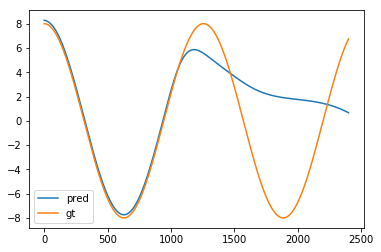

In [10]:
tevals = torch.arange(0,24.01,0.01)
tevals.to(device)
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(f.detach().numpy(),label='pred')
plt.plot(8*np.cos(0.5*tevals.detach().numpy()),label='gt')
plt.legend()

Parameter containing:
tensor([[-0.3000]], requires_grad=True) tensor([ 0.8640,  0.8634,  0.8630,  ..., -0.5321, -0.5290, -0.5259],
       grad_fn=<SelectBackward>) tensor([[-0.2592, -0.2591, -0.2589,  ...,  0.1596,  0.1587,  0.1578]],
       grad_fn=<MulBackward0>)


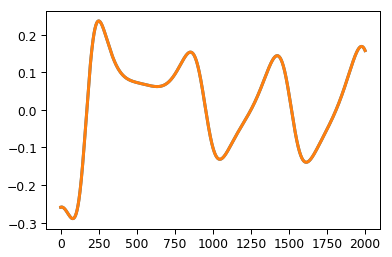

In [28]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    f = model_type.get_D()
    print(f,q[:,1],(f*q[:,1]))
    plt.plot((f[0]*q[:,1]).detach().numpy(),label='pred')
    plt.plot(-0.3*q[:,1].detach().numpy(),label='gt')
    break

In [11]:
q = torch.arange(-5,5,0.1)
qd = torch.arange(-5,5,0.1)
q= q.float()
qd = qd.float()
q.requires_grad = True
qd.requires_grad = True
qvec = torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1)
f = model_type.get_H(qvec)


In [12]:
qm,qdm = torch.meshgrid(q,qd)

In [13]:
f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))

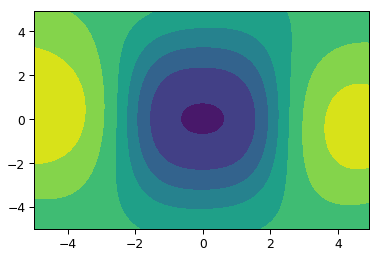

In [14]:
plt.contourf(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy())

In [47]:

model_type.f3.weight

Parameter containing:
tensor([[-2.8749e-02, -3.5966e-02,  6.8856e-02,  5.3383e-02,  4.3093e-02,
         -5.4524e-02, -1.0189e-02, -1.4727e-02,  7.1466e-02, -4.2445e-02,
         -4.4129e-02,  1.0007e-01,  4.1829e-02, -1.1200e-01, -3.0512e-02,
          8.2839e-02,  1.3796e-01, -8.6580e-02,  9.0889e-03,  6.0140e-02,
         -3.4457e-02, -5.2510e-04,  5.2127e-04, -7.8671e-03,  6.1372e-02,
          1.0587e-03, -1.0371e-01, -9.7648e-02,  8.9857e-02, -2.5417e-03,
          1.3451e-01,  1.5510e-02, -1.7066e-02,  6.9484e-02,  2.9604e-02,
         -1.3987e-02,  3.1895e-02,  1.1272e-01, -2.5302e-02,  4.0529e-02,
         -1.1893e-01, -4.2077e-02, -1.1450e-01,  1.6553e-01,  1.2852e-01,
          2.1697e-01, -5.6715e-02, -1.4004e-01,  2.9060e-02, -8.8631e-02,
          3.2727e-02, -2.1741e-03,  9.1915e-02,  6.5766e-03, -8.8785e-04,
          6.5643e-04, -6.3300e-02,  1.2166e-02, -5.3498e-02,  6.5754e-04,
         -1.5640e-02, -4.0288e-03, -3.3099e-02,  3.3492e-02,  1.9404e-04,
          1.0777